# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import cv2
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,random_split,Subset
import torchvision
import torchvision.transforms.functional as tf
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights
import albumentations as A

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Configuration

In [2]:
img_dir="/kaggle/input/flood-area-segmentation/Image"
mask_dir="/kaggle/input/flood-area-segmentation/Mask"

device="cuda" if torch.cuda.is_available() else "cpu"
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

classes=2

learning_rate=0.00005
weight_decay=0.001
epochs=50

model_weights_file="model.pth"

# Exploratory Data Analysis

In [3]:
"""The dtype of flood mask is unit8, it contains values from 0 to 255 with 
   majority being 0 and 255. **Values other then 0,255 needs to be changed as 
   they results into different classes, model output being CxHxW where C is the 
   no of distinct values in the mask**. Therefore we will convert all values 
   greater then 128 to 255 and less then to 0. This ensures in having a binary 
   mask for the problem for segmenting flood water in image."""

mask_pth="/kaggle/input/flood-area-segmentation/Mask/1002.png"
mask=cv2.imread(mask_pth,cv2.IMREAD_GRAYSCALE)
print(f"Shape: {mask.shape}, Dtype: {mask.dtype}")
print(f"No of distinct values: {len(np.unique(mask))}")

Shape: (523, 929), Dtype: uint8
No of distinct values: 255


In [4]:
"For every image there is a corresponding mask"

no_of_imgs=len(os.listdir(img_dir))
no_of_masks=len(os.listdir(mask_dir))

print(f"Number of images: {no_of_imgs}")
print(f"Number of masks: {no_of_masks}")

Number of images: 290
Number of masks: 290


In [5]:
"""There are certain images and their corresponding masks in datastes where
   their is mismatch in their dimension, examining the cases, the mask are also 
   not the correct label. Therefore these cases are discarded from the dataset"""

ignore=[]
img_list=sorted(os.listdir(img_dir))

for img_name in img_list:
    
    image_path=os.path.join(img_dir,img_name)
    image=Image.open(image_path).convert("RGB")
    image=np.array(image)
    i_shape=image.shape[:2]
        
    mask_path=os.path.join(mask_dir,img_name[:-4]+".png")
    mask=Image.open(mask_path)
    mask=np.array(mask)
    m_shape=mask.shape
    
    if i_shape!=m_shape:
        ignore.append(img_name)
        print(f"\n\n{img_name}")
        print(i_shape)
        print(m_shape)



1061.jpg
(440, 660)
(389, 700)


1079.jpg
(682, 1024)
(422, 759)


14.jpg
(1425, 1900)
(630, 1024)


15.jpg
(630, 1024)
(1425, 1900)


2052.jpg
(490, 1012)
(800, 1200)


2053.jpg
(800, 1200)
(490, 1012)


3059.jpg
(400, 650)
(1005, 1920)


In [6]:
ignore

['1061.jpg',
 '1079.jpg',
 '14.jpg',
 '15.jpg',
 '2052.jpg',
 '2053.jpg',
 '3059.jpg']

# Image Augmentation

In [7]:
train_transform=A.Compose([A.HorizontalFlip(),
                           A.ShiftScaleRotate(rotate_limit=10),
                           A.OneOf(
                                   [A.CLAHE(),
                                    A.RandomBrightnessContrast(),
                                    A.HueSaturationValue()],p=1),
                           A.GaussNoise(),
                           A.RandomResizedCrop(height=480,width=480),
                           A.Normalize()])
                           
val_transform=A.Compose([A.Resize(height=480,width=480),
                         A.Normalize()])

# Custom Datasets

In [8]:
class FloodSegmentation(Dataset):
    def __init__(self,img_dir,mask_dir,transform=None):
        super().__init__()
        self.img_dir=img_dir
        self.img_list=sorted([img_name for img_name in os.listdir(self.img_dir)
                              if img_name not in ignore])
        self.mask_dir=mask_dir
        self.transform=transform
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,idx):
        image_path=os.path.join(self.img_dir,self.img_list[idx])
        image=Image.open(image_path).convert("RGB")
        image=np.array(image)
        
        mask_path=os.path.join(self.mask_dir,self.img_list[idx][:-4]+".png")
        mask=Image.open(mask_path)
        mask=np.array(mask)
        mask=np.where(mask>128,1,0)
        
        if self.transform is not None:
            transform=self.transform(image=image,mask=mask)
            image=transform["image"]
            mask=transform["mask"]
            
        mask=torch.as_tensor(mask,dtype=torch.int64)
        image=tf.to_tensor(image)
        
        return image,mask

In [9]:
#setting generator for reproduciblity
train_ds=FloodSegmentation(img_dir,mask_dir,train_transform)
val_ds=FloodSegmentation(img_dir,mask_dir,val_transform)
                 
generator=torch.Generator().manual_seed(42)
train_idx,val_idx=random_split(range(len(train_ds)), [0.75,0.25], generator=generator)

train_ds=Subset(train_ds,train_idx)
val_ds=Subset(val_ds,val_idx)
print(f"Train Dataset: {len(train_ds)}, Validation Dataset: {len(val_ds)}")

Train Dataset: 213, Validation Dataset: 70


# Data Visualization

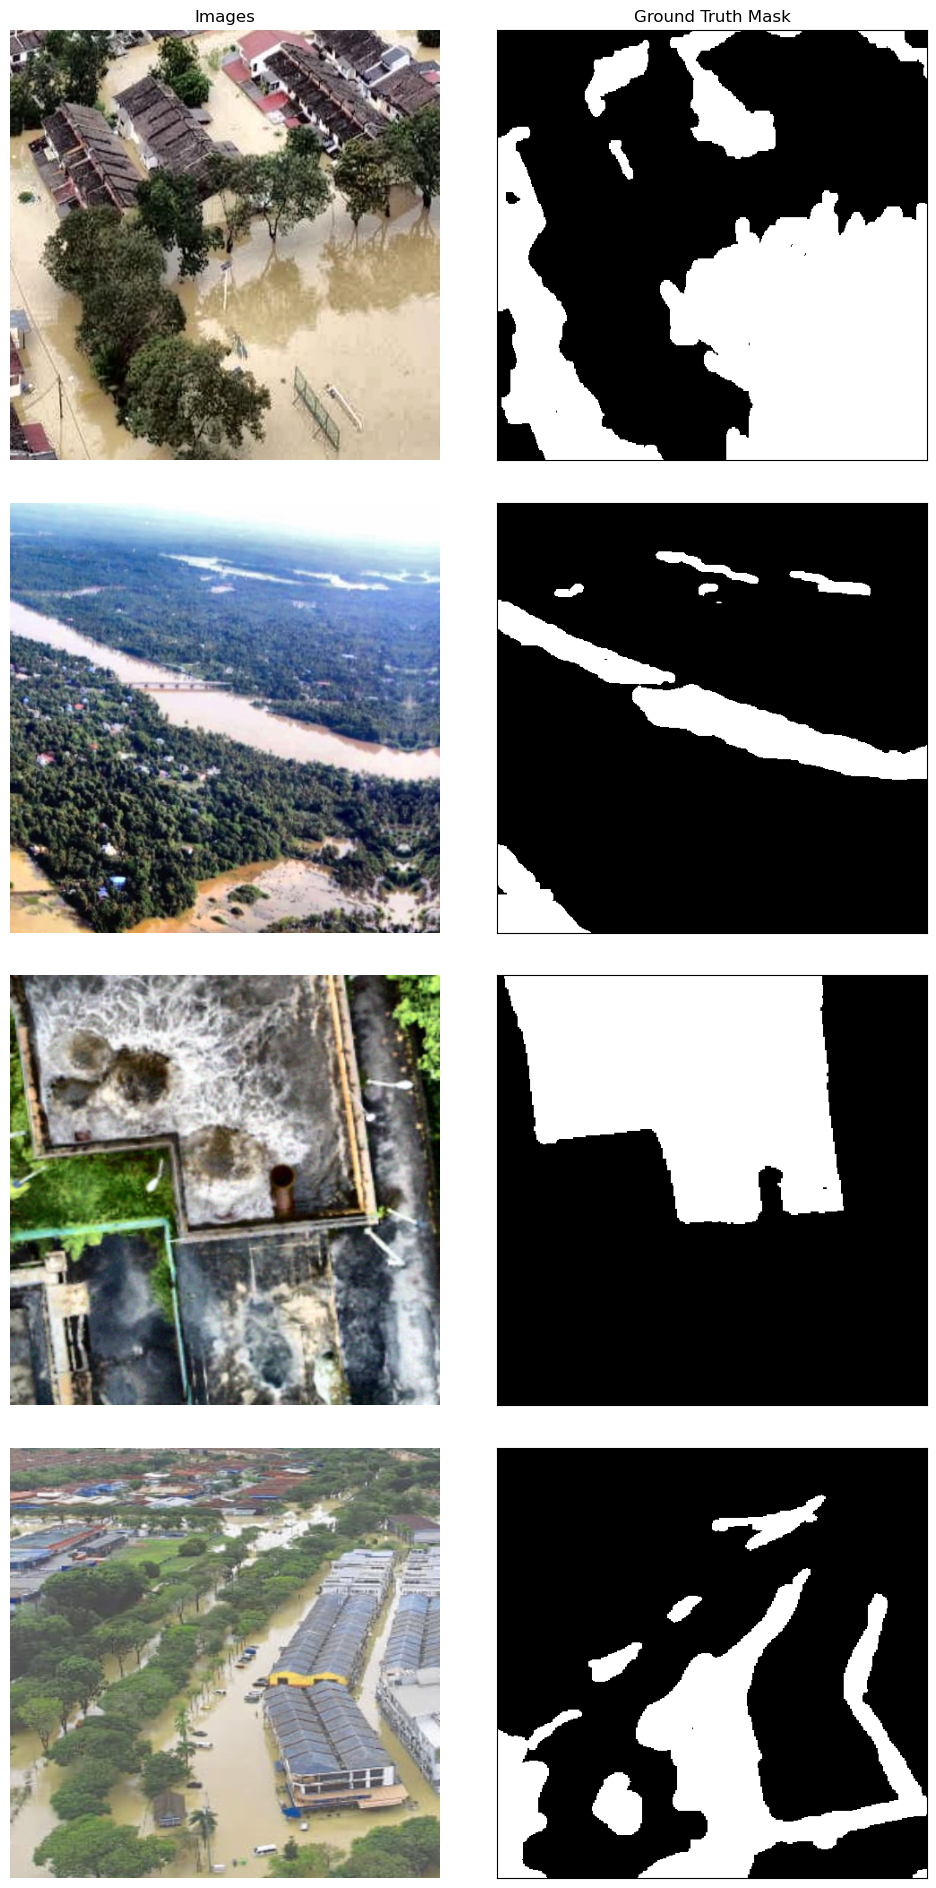

In [10]:
fig,axes=plt.subplots(4,2,figsize=(12,24))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
idxs=np.random.choice(range(len(train_ds)),4)

for i,idx in enumerate(idxs):
    img,mask=train_ds[idx]
    
    #Image
    axes[i,0].imshow(np.transpose(img.numpy(),(1,2,0))*std+mean);
    axes[i,0].axis("off");
    
    #Masks
    axes[i,1].imshow(mask.numpy(),cmap="gray");
    axes[i,1].set_xticks([]);
    axes[i,1].set_yticks([]);
    
axes[0,0].set_title("Images");
axes[0,1].set_title("Ground Truth Mask");
plt.savefig("1.png")

# DataLoader

In [11]:
train_dl=DataLoader(train_ds,batch_size=4,shuffle=True,num_workers=os.cpu_count(),
                    pin_memory=True if device=="cuda" else False,drop_last=True)
val_dl=DataLoader(val_ds,batch_size=4,shuffle=False,num_workers=os.cpu_count(),
                  pin_memory=True if device=="cuda" else False,drop_last=True)

# Model

In [12]:
model=deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT,aux_loss=True)
model.classifier[4]=nn.Conv2d(256, classes, kernel_size=(1, 1))
model.aux_classifier[4]=nn.Conv2d(256, classes, kernel_size=(1, 1))

model.to(device)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 283MB/s] 


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [13]:
modulelist=[]
for name,children in model.backbone.named_children():
    modulelist.append(name)
    
print(modulelist)

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4']


In [14]:
"""We will the backbone layers till layer2, as layer3 will be used for auxiliary
   loss calculation and layer4 will be used for main loss calculation."""

for name,children in model.backbone.named_children():
    if name not in ["layer3","layer4"]:
        for namel,params in children.named_parameters():
            params.requires_grad=False

In [15]:
parameters=[params for params in model.parameters() if params.requires_grad]

loss_fn=nn.CrossEntropyLoss(reduction="mean")
optimizer=optim.Adam(parameters,lr=learning_rate,weight_decay=weight_decay)
lr_scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, 
                                                  patience=7, threshold=0.0001)

# Utilities

In [16]:
class Metric():
    def __init__(self,predictions,masks,nclasses):
        self.predictions=predictions
        self.masks=masks
        self.classes=nclasses
        self.epsilon=10e-6
        
    def accuracy(self):
        with torch.no_grad():
            predictions=torch.argmax(self.predictions,dim=1)
            masks=self.masks
            correct=(predictions==masks).sum().item()
            total=predictions.numel()
            accuracy=correct/total
            
            return accuracy

# Training

In [17]:
def get_lr(optimizer):
    for params in optimizer.param_groups:
        return params["lr"]

In [18]:
loss_history={"training_loss":[],
              "training_accuracy":[],
              "validation_loss":[],
              "validation_accuracy":[]}

train_len=len(train_dl)
val_len=len(val_dl)

best_validation_loss=np.inf
best_weights=copy.deepcopy(model.state_dict())

for epoch in range(epochs):
    
    training_loss=0.0
    training_accuracy=0.0
    validation_loss=0.0
    validation_accuracy=0.0
    
    current_lr=get_lr(optimizer)
    
    model.train()
    for imgs,masks in train_dl:
        imgs,masks=imgs.to(device),masks.to(device)
               
        prediction=model(imgs)
        loss=loss_fn(prediction["out"],masks)+0.3*loss_fn(prediction["aux"],masks)
        training_loss+=loss.item()
        metric=Metric(prediction["out"],masks,2)
        training_accuracy+=metric.accuracy()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        for imgs,masks in val_dl:
            imgs,masks=imgs.to(device),masks.to(device)
            prediction=model(imgs)
            loss=loss_fn(prediction["out"],masks)+0.3*loss_fn(prediction["aux"],masks)
            validation_loss+=loss.item()
            metric=Metric(prediction["out"],masks,2)
            validation_accuracy+=metric.accuracy()        
            
    lr_scheduler.step(validation_loss)
    if current_lr!=get_lr(optimizer):
        print("Loading best Model weights")
        model.load_state_dict(best_weights)
    
    if validation_loss<best_validation_loss:
        best_validation_loss=validation_loss
        best_weights=copy.deepcopy(model.state_dict())
        print("Updating Best Model weights")
        
    
    loss_history["training_loss"].append(training_loss/train_len)
    loss_history["training_accuracy"].append(training_accuracy/train_len)
    loss_history["validation_loss"].append(validation_loss/val_len)
    loss_history["validation_accuracy"].append(validation_accuracy/val_len)
            
    print(f"\n{epoch+1}/{epochs}")
    print(f"Training Loss: {training_loss/train_len}")
    print(f"Validation_loss: {validation_loss/val_len}")
    print("\n"+"*"*50)

torch.save(best_weights,model_weights_file)

Updating Best Model weights

1/50
Training Loss: 0.5889743279735997
Validation_loss: 0.4403451926567975

**************************************************
Updating Best Model weights

2/50
Training Loss: 0.39096763898741527
Validation_loss: 0.3612508607261321

**************************************************
Updating Best Model weights

3/50
Training Loss: 0.36810057849254246
Validation_loss: 0.3491464967236799

**************************************************
Updating Best Model weights

4/50
Training Loss: 0.36360808447846826
Validation_loss: 0.31991437603445616

**************************************************

5/50
Training Loss: 0.332629641834295
Validation_loss: 0.3339703398592332

**************************************************
Updating Best Model weights

6/50
Training Loss: 0.30628200325201144
Validation_loss: 0.3163476104245466

**************************************************

7/50
Training Loss: 0.3160827474774055
Validation_loss: 0.3271465143736671

***********

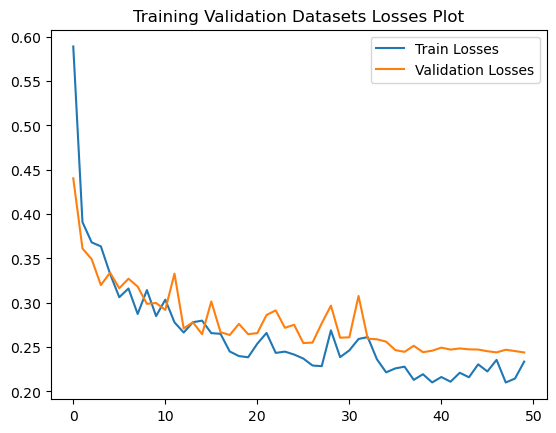

In [19]:
sns.lineplot(x=range(epochs),y=loss_history["training_loss"],label="Train Losses");
sns.lineplot(x=range(epochs),y=loss_history["validation_loss"],label="Validation Losses");
plt.title("Training Validation Datasets Losses Plot");
plt.legend();
plt.savefig("2.png")

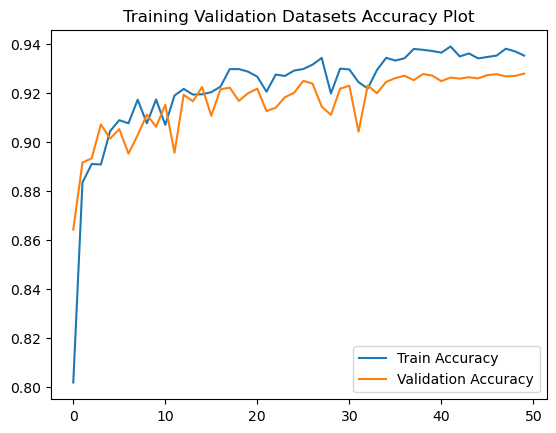

In [20]:
sns.lineplot(x=range(epochs),y=loss_history["training_accuracy"],label="Train Accuracy");
sns.lineplot(x=range(epochs),y=loss_history["validation_accuracy"],label="Validation Accuracy");
plt.title("Training Validation Datasets Accuracy Plot");
plt.legend();
plt.savefig("3.png")

# Inference

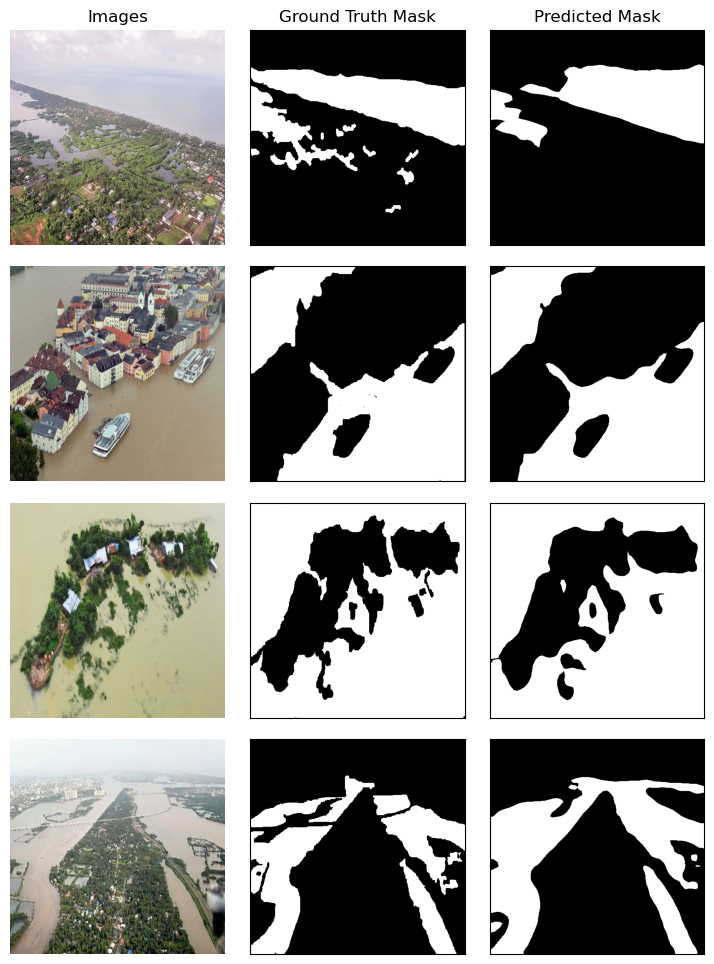

In [21]:
fig,axes=plt.subplots(4,3,figsize=(9,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,masks=next(iter(val_dl))
imgs,masks=imgs.to(device),masks.to(device)
model.eval()
with torch.no_grad():
    predictions=model(imgs)["out"]
    prediction_masks=torch.argmax(predictions,dim=1)

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    gt_mask=masks[idx]
    predict_mask=prediction_masks[idx]
    
    #Image
    axes[i,0].imshow(np.transpose(img.cpu().numpy(),(1,2,0))*std+mean)
    axes[i,0].axis("off")
    
    #Ground Truth Masks
    axes[i,1].imshow(gt_mask.cpu().numpy(),cmap="gray")
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    
    #Ground Truth Masks
    axes[i,2].imshow(predict_mask.cpu().numpy(),cmap="gray")
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])
    
axes[0,0].set_title("Images");
axes[0,1].set_title("Ground Truth Mask");
axes[0,2].set_title("Predicted Mask");

plt.savefig("4.png")

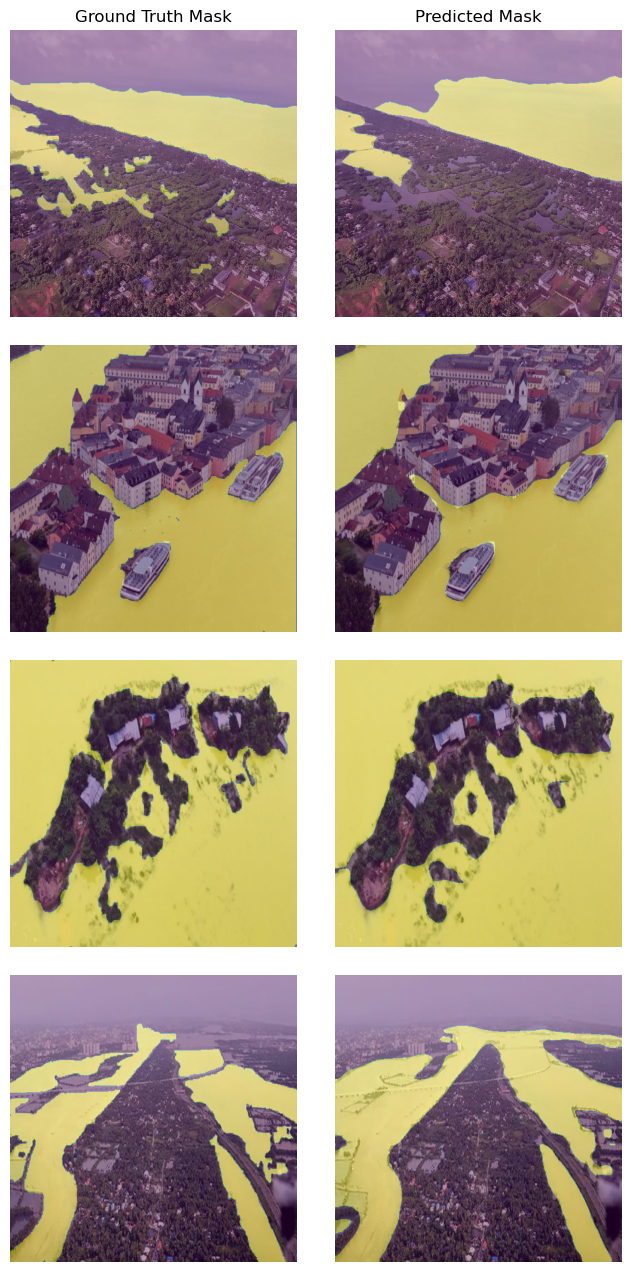

In [22]:
fig,axes=plt.subplots(4,2,figsize=(8,16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

imgs,masks=next(iter(val_dl))
imgs,masks=imgs.to(device),masks.to(device)
model.eval()
with torch.no_grad():
    predictions=model(imgs)["out"]
    prediction_masks=torch.argmax(predictions,dim=1)

for i,idx in enumerate(range(len(imgs))):
    img=imgs[idx]
    gt_mask=masks[idx]
    predict_mask=prediction_masks[idx]
    
    #Image with ground truth mask overlapped
    axes[i,0].imshow(np.transpose(img.cpu().numpy(),(1,2,0))*std+mean)
    axes[i,0].imshow(gt_mask.cpu().numpy(),alpha=0.4)
    axes[i,0].axis("off")
    
    #Image with predicted mask overlapped
    axes[i,1].imshow(np.transpose(img.cpu().numpy(),(1,2,0))*std+mean)
    axes[i,1].imshow(predict_mask.cpu().numpy(),alpha=0.4)
    axes[i,1].axis("off")
    
axes[0,0].set_title("Ground Truth Mask");
axes[0,1].set_title("Predicted Mask");

plt.savefig("5.png")